In [1]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Выделение новых признаков

## Загрузка и обработка датасета

In [4]:
df = pd.read_excel('Flu-IC50.xlsx').dropna(how='all', axis='columns')
df.head()

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


## Инициализация модели

In [5]:
model_name = "ncfrey/ChemGPT-1.2B"
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)  # model_max_length=512

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

In [6]:
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.resize_token_embeddings(len(tokenizer))

Embedding(684, 2048)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


In [8]:
model = model.to(device)

## Выделение признаков

In [9]:
smiles_data = list(df['SMILES'])

In [10]:
def batch_encode(model, tokenizer, smiles_data, batch_size):
    model.eval()
    outputs = []

    for i in tqdm(range(0, len(smiles_data), batch_size)):
        batch = smiles_data[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            batch_outputs = model(**inputs)
            outputs.append(batch_outputs.hidden_states[-1].mean(dim=1).cpu())  # Среднее значение по последнему скрытому слою

    return torch.cat(outputs, dim=0)

In [11]:
batch_size = 100
features = batch_encode(model, tokenizer, smiles_data, batch_size)

100%|██████████| 364/364 [11:45<00:00,  1.94s/it]


In [12]:
features

tensor([[-1.1516, -0.9379, -0.5215,  ...,  0.4938, -0.9581, -0.3757],
        [-1.0151, -0.6387, -0.2840,  ...,  0.7209, -0.6732, -0.9545],
        [-1.3111, -0.6687, -0.5287,  ...,  0.5113, -0.4816, -0.5459],
        ...,
        [-1.1651, -0.8008, -0.3790,  ...,  0.7000, -0.5372, -0.6020],
        [-1.0483, -0.3493, -1.3230,  ...,  1.1504, -0.8881, -0.9153],
        [-1.0975, -0.8789, -0.2058,  ...,  0.6031, -0.4526, -0.7605]])

## Добавление признаков в dataframe

In [13]:
if features.is_cuda:
    features = features.cpu()

features_numpy = features.numpy()

In [14]:
features_df = pd.DataFrame(features_numpy, columns=[f"feature_{i+1}" for i in range(features_numpy.shape[1])])

In [15]:
df = pd.concat([df, features_df], axis=1)
df

,Title,IC50,SMILES,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047,feature_2048
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,-1.151579,-0.937891,-0.521495,-1.411179,-0.517593,-1.016551,0.878954,...,0.677162,0.120728,-1.011443,-0.967161,1.988145,1.110236,0.720317,0.493765,-0.958051,-0.375662
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,-1.015117,-0.638654,-0.283993,-1.615638,-0.398137,-0.856765,0.257554,...,1.469956,-0.027024,-0.986622,-1.066307,1.198120,0.840875,1.201059,0.720945,-0.673185,-0.954526
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,-1.311120,-0.668723,-0.528672,-0.934477,-0.818402,-1.051374,0.371338,...,1.667345,-0.728834,-1.648911,-0.812627,1.710945,0.599128,0.950733,0.511317,-0.481609,-0.545850
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,-1.311120,-0.668723,-0.528672,-0.934477,-0.818402,-1.051374,0.371338,...,1.667345,-0.728834,-1.648911,-0.812627,1.710945,0.599128,0.950733,0.511317,-0.481609,-0.545850
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,-1.397133,-0.951692,-0.617460,-0.702339,-0.849676,-1.297619,1.053861,...,0.858343,-0.740101,-1.912961,-0.646999,1.894874,1.446777,1.009371,1.266567,-0.491979,0.565882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...,-1.091735,-1.213884,-0.009048,-0.802079,-0.665577,-1.317058,0.339364,...,1.234312,-0.698345,-2.038218,-0.929983,1.978950,0.532762,0.882891,0.664435,-0.582903,-0.403047
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O,-1.048266,-0.349271,-1.323043,-2.365743,-0.365980,-0.820695,0.358553,...,1.160540,0.088154,-0.301020,-1.162708,-0.192366,1.236992,1.212626,1.150433,-0.888111,-0.915328
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...,-1.165116,-0.800784,-0.378953,-0.899052,-0.567618,-1.084433,0.176378,...,1.248282,-0.698409,-1.602270,-0.830029,1.731027,0.650812,1.339946,0.699958,-0.537172,-0.602000
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O,-1.048266,-0.349271,-1.323043,-2.365743,-0.365980,-0.820695,0.358553,...,1.160540,0.088154,-0.301020,-1.162708,-0.192366,1.236992,1.212626,1.150433,-0.888111,-0.915328


### Сохранение и загрузка датасета

In [16]:
file_name = 'flu_ic50_chem_gpt_features.csv'

In [17]:
from google.colab import files

df.to_csv(file_name, encoding='utf-8', index=False)
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Регрессия

## Загрузка и обработка датасета

In [59]:
df = pd.read_csv(file_name)

In [42]:
df.head()

,Title,IC50,SMILES,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047,feature_2048
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,-1.151579,-0.937890,-0.521495,-1.411179,-0.517593,-1.016552,0.878954,...,0.677162,0.120728,-1.011443,-0.967161,1.988145,1.110236,0.720317,0.493765,-0.958051,-0.375662
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,-1.015117,-0.638654,-0.283993,-1.615638,-0.398137,-0.856765,0.257554,...,1.469956,-0.027024,-0.986622,-1.066307,1.198120,0.840875,1.201059,0.720945,-0.673185,-0.954526
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,-1.311120,-0.668723,-0.528672,-0.934477,-0.818402,-1.051374,0.371338,...,1.667345,-0.728834,-1.648911,-0.812627,1.710945,0.599128,0.950733,0.511317,-0.481609,-0.545850
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,-1.311120,-0.668723,-0.528672,-0.934477,-0.818402,-1.051374,0.371338,...,1.667345,-0.728834,-1.648911,-0.812627,1.710945,0.599128,0.950733,0.511317,-0.481609,-0.545850
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,-1.397133,-0.951692,-0.617460,-0.702339,-0.849676,-1.297619,1.053861,...,0.858343,-0.740101,-1.912961,-0.646999,1.894874,1.446776,1.009371,1.266566,-0.491979,0.565882


In [43]:
df['IC50'] = df['IC50'].apply(lambda x: x if x < 300 else 300)
df['IC50'] = df['IC50'].apply(lambda x: np.log(x + 1))

<Axes: xlabel='IC50', ylabel='Count'>

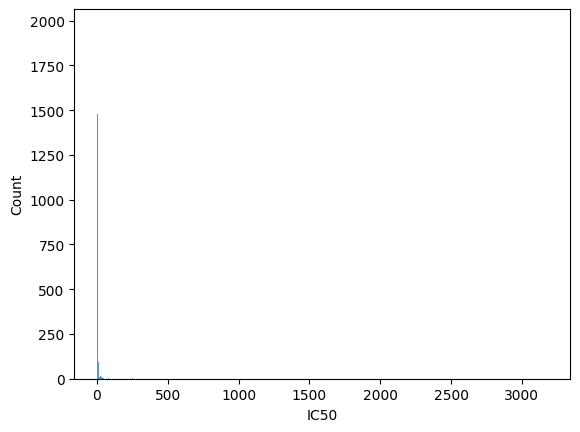

In [60]:
sns.histplot(df['IC50'])

In [61]:
y = df['IC50'].values
X = df.drop(['Title', 'IC50', 'SMILES'], axis=1).values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.25, random_state=seed)

## Обучение моделей

In [63]:
def count_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred, squared=False)
    print("Среднеквадратичная ошибка (RMSE):", mse)

### LinearRegression

без обработки - 168.35423323244098

ограничение IC50 - 75.06741892728459

логарифмирование IC50 - 2.3095431642673203

In [64]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [65]:
model.fit(X_train, y_train);

In [66]:
y_pred = model.predict(X_test)

count_metrics(y_test, y_pred)

Среднеквадратичная ошибка (RMSE): 168.35423323244098


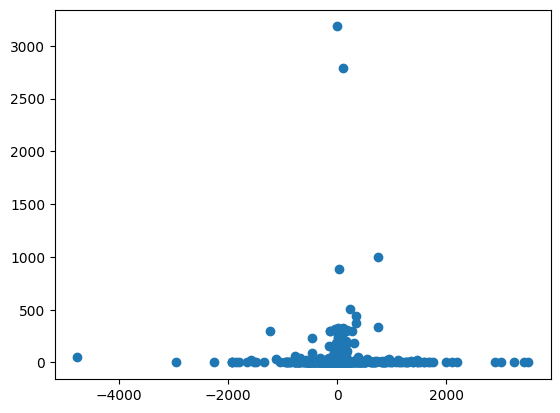

In [67]:
plt.scatter(y_pred, y_test);

### CatBoostRegressor

без обработки - 47.65666735851152

ограничение IC50 - 17.295282901378012

логарифмирование IC50 - 0.6969771357231117

In [32]:
!pip install catboost &> /dev/null

In [72]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=100)

In [73]:
model.fit(X_train, y_train)

Learning rate set to 0.448795
0:	learn: 42.2291108	total: 842ms	remaining: 1m 23s
1:	learn: 39.5359719	total: 1.35s	remaining: 1m 6s
2:	learn: 37.6452347	total: 1.85s	remaining: 60s
3:	learn: 35.8165594	total: 2.4s	remaining: 57.6s
4:	learn: 34.4799633	total: 2.95s	remaining: 56s
5:	learn: 33.6080971	total: 3.49s	remaining: 54.6s
6:	learn: 32.9670771	total: 4.03s	remaining: 53.5s
7:	learn: 32.1640779	total: 4.53s	remaining: 52.1s
8:	learn: 31.6714999	total: 5.08s	remaining: 51.3s
9:	learn: 31.0877628	total: 5.59s	remaining: 50.4s
10:	learn: 30.6173537	total: 6.12s	remaining: 49.5s
11:	learn: 30.4031486	total: 6.62s	remaining: 48.6s
12:	learn: 30.1096234	total: 7.13s	remaining: 47.7s
13:	learn: 29.7819766	total: 7.68s	remaining: 47.2s
14:	learn: 29.3843796	total: 8.24s	remaining: 46.7s
15:	learn: 29.2502407	total: 8.75s	remaining: 45.9s
16:	learn: 28.8138741	total: 9.26s	remaining: 45.2s
17:	learn: 28.3448110	total: 9.8s	remaining: 44.7s
18:	learn: 28.1011168	total: 10.3s	remaining: 43.

In [74]:
y_pred = model.predict(X_test)

count_metrics(y_test, y_pred)

Среднеквадратичная ошибка (RMSE): 47.65666735851152


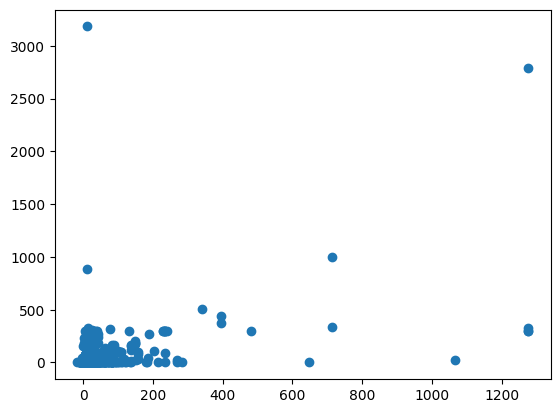

In [71]:
plt.scatter(y_pred, y_test);

### XGBRegressor

без обработки - 46.5376338709502

ограничение IC50 - 17.630941693219235

логарифмирование IC50 - 0.6910764986254054

In [75]:
from xgboost import XGBRegressor

model = XGBRegressor()

In [76]:
model.fit(X_train, y_train);

In [77]:
y_pred = model.predict(X_test)

count_metrics(y_test, y_pred)

Среднеквадратичная ошибка (RMSE): 46.5376338709502


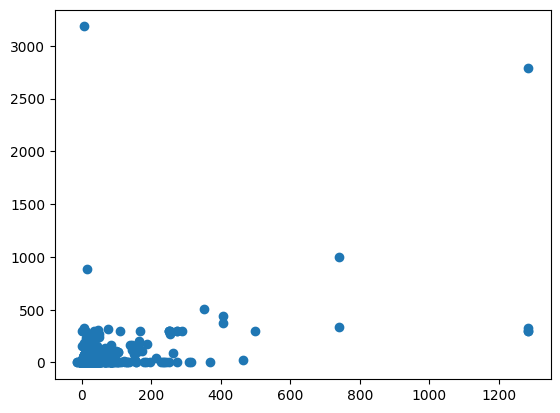

In [78]:
plt.scatter(y_pred, y_test);